This notebook is part of the `kikuchipy` documentation https://kikuchipy.org.
Links to the documentation won't work from the notebook.

# Reference frames

## Sample-detector geometry

The figures below show the
[sample reference frame](#detector-sample-geometry) and the
[detector reference frame](#detector-coordinates) used in kikuchipy, all of
which are right handed. In short, the sample reference frame is the one used by
EDAX TSL, RD-TD-ND, while the pattern center is defined as in the Bruker
software.

<img id="detector-sample-geometry" src="_static/image/reference_frames/detector_sample_geometry.png">

In **(a)**, a schematic of the microscope chamber shows the orientation of the
crystal reference frame, RD-TD-ND, attached to the sample. The
$x_{euler}-y_{euler}-z_{euler}$ crystal reference frame used by Bruker
Nano EDAX TSL is shown for reference. An EBSD pattern on the detector screen is
viewed from behind the screen towards the sample. **(b)** shows how the EBSD map
appears within the data collection software, with the crystal reference frame
and the scanning reference frame, $x_{scan}-y_{scan}-z_{scan}$, attached.
**(c)** shows the relationship between the crystal reference frame and the
detector reference frame, $x_{detector}-y_{detector}-z_{detector}$, with
the projection center highlighted. The detector tilt $\theta$ and sample tilt
$\sigma$, in this case $10^{\circ}$ and $70^{\circ}$, respectively, are also
shown.

<img id="detector-coordinates" src="_static/image/reference_frames/detector_gnomonic_coordinates.jpg">

The above figure shows the EBSD pattern in the
[sample reference frame figure](#detector-sample-geometry) **(a)** as viewed
from behind the screen towards the sample (left), with the detector reference
frame the same as in **(c)** with its origin (0, 0) in the upper left pixel. The
detector pixels' gnomonic coordinates can be described with a calibrated
projection center (PC) (right), with the gnomonic reference frame origin (0, 0)
in ($PC_x, PC_y$). The circles indicate the angular distance from the PC in
steps of $10^{\circ}$.

## The EBSD detector

All relevant parameters for the sample-detector geometry are stored in an
[kikuchipy.detectors.EBSDDetector](reference.rst#kikuchipy.detectors.EBSDDetector)
instance. Let's first import necessary libraries and a small Nickel EBSD test
data set

In [1]:
# Exchange "inline" for:
# "qt5" for interactive plotting from the pyqt package
# "notebook" for inline interactive plotting when running on Binder
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 15
import numpy as np
import kikuchipy as kp


s = kp.data.nickel_ebsd_small()  # Use kp.load("data.h5") to load your own data
s

<EBSD, title: patterns My awes0m4 ..., dimensions: (3, 3|60, 60)>

Then we can define a detector with the same parameters as the one used to
acquire the small Nickel data set

In [2]:
detector = kp.detectors.EBSDDetector(
    shape=s.axes_manager.signal_shape[::-1],
    pc=[0.421, 0.779, 0.505],
    convention="tsl",
    px_size=70,  # microns
    binning=8,
    tilt=0,
    sample_tilt=70
)
detector

EBSDDetector (60, 60), px_size 70 um, binning 8, tilt 0, pc (0.421, 0.221, 0.505)

In [3]:
detector.pc_tsl()

array([[0.421, 0.779, 0.505]])

The projection/pattern center (PC) is stored internally in the Bruker
convention:
- PCx is measured from the left border of the detector in fractions of detector
  width.
- PCy is measured from the top border of the detector in fractions of detector
  height.
- PCz is the distance from the detector scintillator to the sample divided by
  pattern height.

Above, the PC was passed in the EDAX TSL convention. Passing the PC in the
Bruker, Oxford, or EMsoft v4 or v5 convention is also supported. Likewise, the
PC can be returned in all conventions via
[EBSDDetector.pc_emsoft()](reference.rst#kikuchipy.detectors.EBSDDetector.pc_emsoft)
and similar. Conversions between conventions are implemented as described in
<cite data-cite="jackson2019dictionary">Jackson et al. (2019)</cite>. The
unbinned pixel size $\delta$, binning factor $b$ and number of pixel rows $s_y$
and columns $s_x$ are needed to convert a PC between the EMsoft and Bruker
conventions:

- EDAX TSL or Oxford to Bruker

$$
[PC_x, PC_y, PC_z] = [x^*, 1 - y^*, z^*].
$$

- EMsoft to Bruker, with $v = -1$ for EMsoft v5 and $+1$ for v4

$$
[PC_x, PC_y, PC_z] = \left[
\frac{1}{2} + v\frac{x_{pc}}{s_x b},
\frac{1}{2} - \frac{y_{pc}}{s_y b},
\frac{L}{s_y \delta b}
\right].
$$

The detector can be plotted to show whether the average PC is placed as
expected using
[EBSDDetector.plot()](reference.rst#kikuchipy.detectors.EBSDDetector.plot) (see
its docstring for a complete explanation of its parameters)

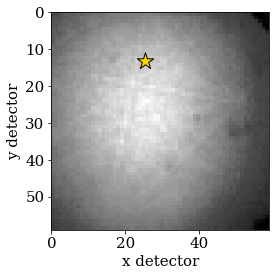

In [4]:
detector.plot(pattern=s.inav[0, 0].data)

This will produce a figure similar to the left panel in the
[detector coordinates figure](#detector-coordinates) above, without the arrows
and colored labels.

Multiple PCs with a 1D or 2D navigation shape can be passed to the `pc`
parameter upon initialization, or can be set directly. This gives the detector
a navigation shape (not to be confused with the detector shape) and a navigation
dimension (maximum of two)

In [5]:
detector.pc = np.ones([3, 4, 3]) * [0.421, 0.779, 0.505]
detector.navigation_shape

(3, 4)

In [6]:
detector.navigation_dimension

2

In [7]:
detector.pc = detector.pc[0, 0]
detector.navigation_shape

(1,)

<div class="alert alert-info">

Note

The offset and scale of HyperSpy’s `axes_manager` is fixed for a signal,
meaning that we cannot let the PC vary with scan position if we want to
calibrate the EBSD detector via the `axes_manager`. The need for a varying
PC was the main motivation behind the `EBSDDetector` class.
    
</div>

The right panel in the [detector coordinates figure](#detector-coordinates)
above shows the detector plotted in the gnomonic projection using
[EBSDDetector.plot()](reference.rst#kikuchipy.detectors.EBSDDetector.plot). We
assign 2D gnomonic coordinates ($x_g, y_g$) in a gnomonic projection plane
parallel to the detector screen to a 3D point ($x_d, y_d, z_d$) in the detector
frame as

$$
x_g = \frac{x_d}{z_d}, \qquad y_g = \frac{y_d}{z_d}.
$$

The detector bounds and pixel scale in this projection, per navigation point,
are stored with the detector

In [8]:
detector.bounds

array([ 0, 59,  0, 59])

In [9]:
detector.gnomonic_bounds

array([[-0.83366337,  1.14653465, -0.43762376,  1.54257426]])

In [10]:
detector.x_range

array([[-0.83366337,  1.14653465]])

In [11]:
detector.r_max  # Largest radial distance to PC

array([[1.92199819]])

## Projection center calibration

The gnomonic projection (pattern) center (PC) of an EBSD detector can be
estimated by the "moving-screen" technique
<cite data-cite="hjelen1991electron">Hjelen et al.</cite>. The technique relies
on the assumption that the beam normal, shown in the
[top figure (c)](#detector-sample-geometry) above, is normal to the detector
screen as well as the incoming electron beam, and will therefore intersect the
screen at a position independent of the detector distance (DD). To find this
position, we need two EBSD patterns acquired with a stationary beam but with a
known difference $\Delta z$ in DD, say 5 mm.

First, the goal is to find the pattern position which does not shift between the
two camera positions, ($PC_x$, $PC_y$). This point can be estimated in fractions
of screen width and height, respectively, by selecting the same pattern features
in both patterns. The two points of each pattern feature can then be used to
form a straight line, and two or more such lines should intersect at ($PC_x$,
$PC_y$).

Second, the DD ($PC_z$) can be estimated from the same points. After finding
the distances $L_{in}$ and $L_{out}$ between two points (features) in both
patterns (in = operating position, out = 5 mm from operating position), the DD
can be found from the relation

$$
\mathrm{DD} = \frac{\Delta z}{L_{out}/L_{in} - 1},
$$

where DD is given in the same unit as the known camera distance difference. If
also the detector pixel size $\delta$ is known (e.g. 46 mm / 508 px), $PC_z$ can
be given in the fraction of the detector screen height

$$
PC_z = \frac{\mathrm{DD}}{N_r \delta b},
$$

where $N_r$ is the number of detector rows and $b$ is the binning factor.

Let's find an estimate of the PC from two single crystal Silicon EBSD patterns,
which are included in the [kikuchipy.data](reference.rst#data) module

In [12]:
s_in = kp.data.silicon_ebsd_moving_screen_in(allow_download=True)
s_in.remove_static_background()
s_in.remove_dynamic_background()

s_out5mm = kp.data.silicon_ebsd_moving_screen_out5mm(allow_download=True)
s_out5mm.remove_static_background()
s_out5mm.remove_dynamic_background()

Removing the static background:
[########################################] | 100% Completed |  0.5s
Removing the dynamic background:
[########################################] | 100% Completed |  0.4s
Removing the static background:
[########################################] | 100% Completed |  0.1s
Removing the dynamic background:
[########################################] | 100% Completed |  0.1s


As a first approximation, we can find the detector pixel positions of the same
features in both patterns by plotting them and noting the upper right
coordianates provided by Matplotlib when plotting with an interactive backend
(e.g. qt5 or notebook) and hovering over image pixels

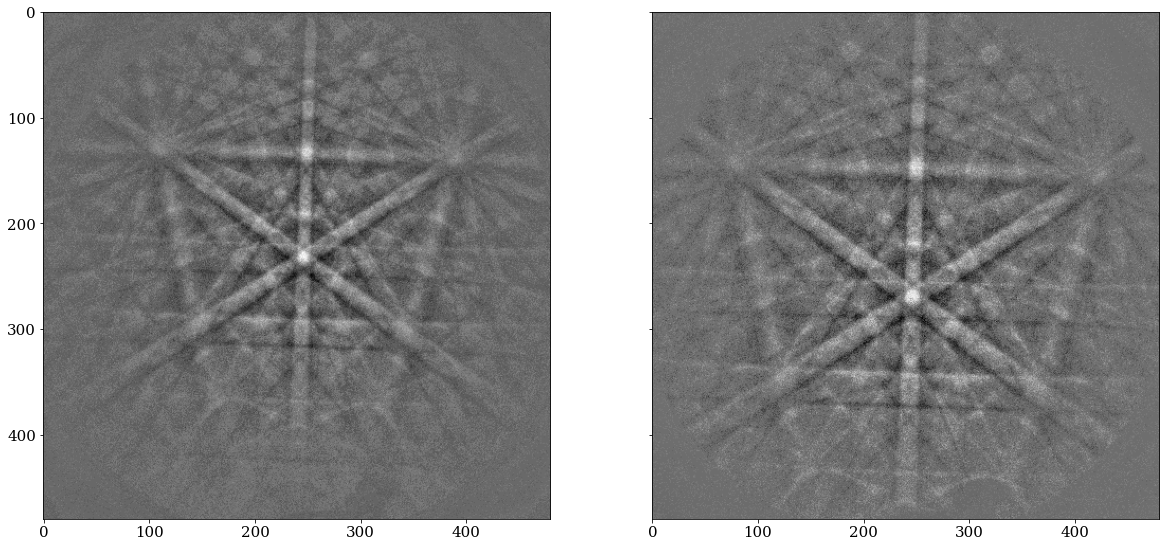

In [13]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(20, 10))
ax[0].imshow(s_in.data, cmap="gray")
_ = ax[1].imshow(s_out5mm.data, cmap="gray")

For this example we choose the positions of three zone axes. The PC calibration
is performed by creating an instance of the
[PCCalibrationMovingScreen](reference.rst#kikuchipy.detectors.PCCalibrationMovingScreen)
class

In [14]:
cal = kp.detectors.PCCalibrationMovingScreen(
    pattern_in=s_in.data,
    pattern_out=s_out5mm.data,
    points_in=[(109, 131), (390, 139), (246, 232)],
    points_out=[(77, 146), (424, 156), (246, 269)],
    delta_z=5,
    px_size=None,  # Default
    convention="tsl",  # Default
)
cal

PCCalibrationMovingScreen: (PCx, PCy, PCz) = (0.5123, 0.8606, 21.6518)
3 points:
[[[109 131]
  [390 139]
  [246 232]]

 [[ 77 146]
  [424 156]
  [246 269]]]

We see that ($PC_x$, $PC_y$) = (0.5123, 0.8606), while DD = 21.7 mm. To get
$PC_z$ in fractions of detector height, we have to provide the detector pixel
size $\delta$ upon initialization, or set it directly and recalculate the PC

In [15]:
cal.px_size = 46 / 508  # mm/px
cal

PCCalibrationMovingScreen: (PCx, PCy, PCz) = (0.5123, 0.8606, 0.4981)
3 points:
[[[109 131]
  [390 139]
  [246 232]]

 [[ 77 146]
  [424 156]
  [246 269]]]

We can visualize the estimation by using the (opinionated) convenience method
[PCCalibrationMovingScreen.plot()](reference.rst#kikuchipy.detectors.PCCalibrationMovingScreen.plot)

In [ ]:
cal.plot()

As expected, the three lines in the right figure meet at a more or less the same
position. We can replot the three images and zoom in on the PC to see how close
they are to each other. We will use two standard deviations of all $PC_x$
estimates as the axis limits (scaled with pattern shape)

In [ ]:
# PCy defined from top to bottom, otherwise "tsl", defined from bottom to top
cal.convention = "bruker"
pcx, pcy, _ = cal.pc
two_std = 2 * np.std(cal.pcx_all, axis=0)

fig, ax = cal.plot(return_fig_ax=True)
ax[2].set_xlim([cal.ncols * (pcx - two_std), cal.ncols * (pcx + two_std)])
_ = ax[2].set_ylim([cal.nrows * ( pcy - two_std), cal.nrows * (pcy + two_std)])

Finally, we can use this PC estimate along with the orientation of the Si
crystal, as determined by Hough indexing with a commercial software, to see how
good the estimate is, by performing a
[geometrical EBSD simulation](geometrical_ebsd_simulations.ipynb) of positions of
Kikuchi band centres and zone axes from the five $\{hkl\}$ families $\{111\}$,
$\{200\}$, $\{220\}$, $\{222\}$, and $\{311\}$

In [ ]:
from diffsims.crystallography import ReciprocalLatticePoint
from orix import crystal_map, quaternion


# Create simulation generator from a detector and crystal phase and orientation
detector = kp.detectors.EBSDDetector(
    shape=cal.shape, pc=cal.pc, sample_tilt=70, convention=cal.convention
)
phase = crystal_map.Phase(space_group=227)
r = quaternion.Rotation.from_euler(np.deg2rad([133.3, 88.7, 177.8]))
simgen = kp.generators.EBSDSimulationGenerator(
    detector=detector, phase=phase, rotations=r
)
simgen.navigation_shape = s_in.axes_manager.navigation_shape

# Specify which plane families for which to simulate bands and zone axes
rlp = ReciprocalLatticePoint(
    phase=phase, hkl=[[1, 1, 1], [2, 0, 0], [2, 2, 0], [2, 2, 2], [3, 1, 1]]
).symmetrise()  # Symmetrise to get all symmetrically equivalent planes
simgeo = simgen.geometrical_simulation(rlp)

#del s_in.metadata.Markers  # Uncomment this if we want to re-add markers
s_in.add_marker(
    marker=simgeo.as_markers(),
    plot_marker=False,
    permanent=True
)
s_in.plot(navigator=None, colorbar=False, axes_off=True, title="")

The PC is not perfect, but the estimate might be good enough for a further PC
and/or orientation refinement.